# Import Required Libraries
Import the necessary libraries, including pandas, lime, and scikit-learn.

In [1]:
import lime
import lime.lime_tabular
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import random

# Load the Iris Dataset
Load the iris dataset using pandas and convert it to a DataFrame.

In [2]:
# Load the iris dataset using pandas and convert it to a DataFrame
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

# Split the data into features and target
X = df.drop(columns=['target'])
y = df['target']

# Split the Data into Training and Testing Sets
Use train_test_split to split the DataFrame into training and testing sets.

In [3]:
# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train a RandomForestClassifier
Train a RandomForestClassifier using the training data.

In [4]:
# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Calculate Feature Limits
Calculate the feature limits for plotting decision boundaries.

In [12]:
# Calculate Feature Limits
n_features = X.shape[1]

feature_means = { i: X.iloc[:,i].mean() for i in range(n_features)}
feature_limits = {}

for i in range(n_features - 1):
    for j in range(i, n_features):
        x_min = X.iloc[:, i].min() - 1
        x_max = X.iloc[:, i].max() + 1
        y_min = X.iloc[:, j].min() - 1
        y_max = X.iloc[:, j].max() + 1
        feature_limits[(i, j)] = (x_min, x_max, y_min, y_max)

# Function to Plot Decision Boundaries
Define a function to plot decision boundaries using the feature limits.

In [13]:
# Function to plot decision boundaries
def plot_decision_boundaries(ax, X, y, clf, feature_pair):
    # Create a mesh grid
    x_min, x_max = X.iloc[:, feature_pair[0]].min() - 1, X.iloc[:, feature_pair[0]].max() + 1
    y_min, y_max = X.iloc[:, feature_pair[1]].min() - 1, X.iloc[:, feature_pair[1]].max() + 1
    x_min, x_max, y_min, y_max = feature_limits[tuple(feature_pair)]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Predict on the mesh grid
    X_full = pd.DataFrame(np.zeros((xx.ravel().shape[0], X.shape[1])), columns=X.columns)
    X_full.iloc[:, feature_pair[0]] = xx.ravel()
    X_full.iloc[:, feature_pair[1]] = yy.ravel()
    for k in range(X.shape[1]):
        if k not in feature_pair:
            X_full.iloc[:, k] = feature_means[k]

    Z = clf.predict(X_full)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3)
    scatter = ax.scatter(
        X.iloc[:, feature_pair[0]], X.iloc[:, feature_pair[1]], c=y, edgecolor="k", marker="o"
    )
    ax.set_xlabel(iris.feature_names[feature_pair[0]])
    ax.set_ylabel(iris.feature_names[feature_pair[1]])
    ax.set_title(
        f"{iris.feature_names[feature_pair[0]]} vs {iris.feature_names[feature_pair[1]]}"
    )
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)

# Function to Create a Grid of Decision Boundary Plots
Define a function to create a grid of decision boundary plots for the trained classifier.

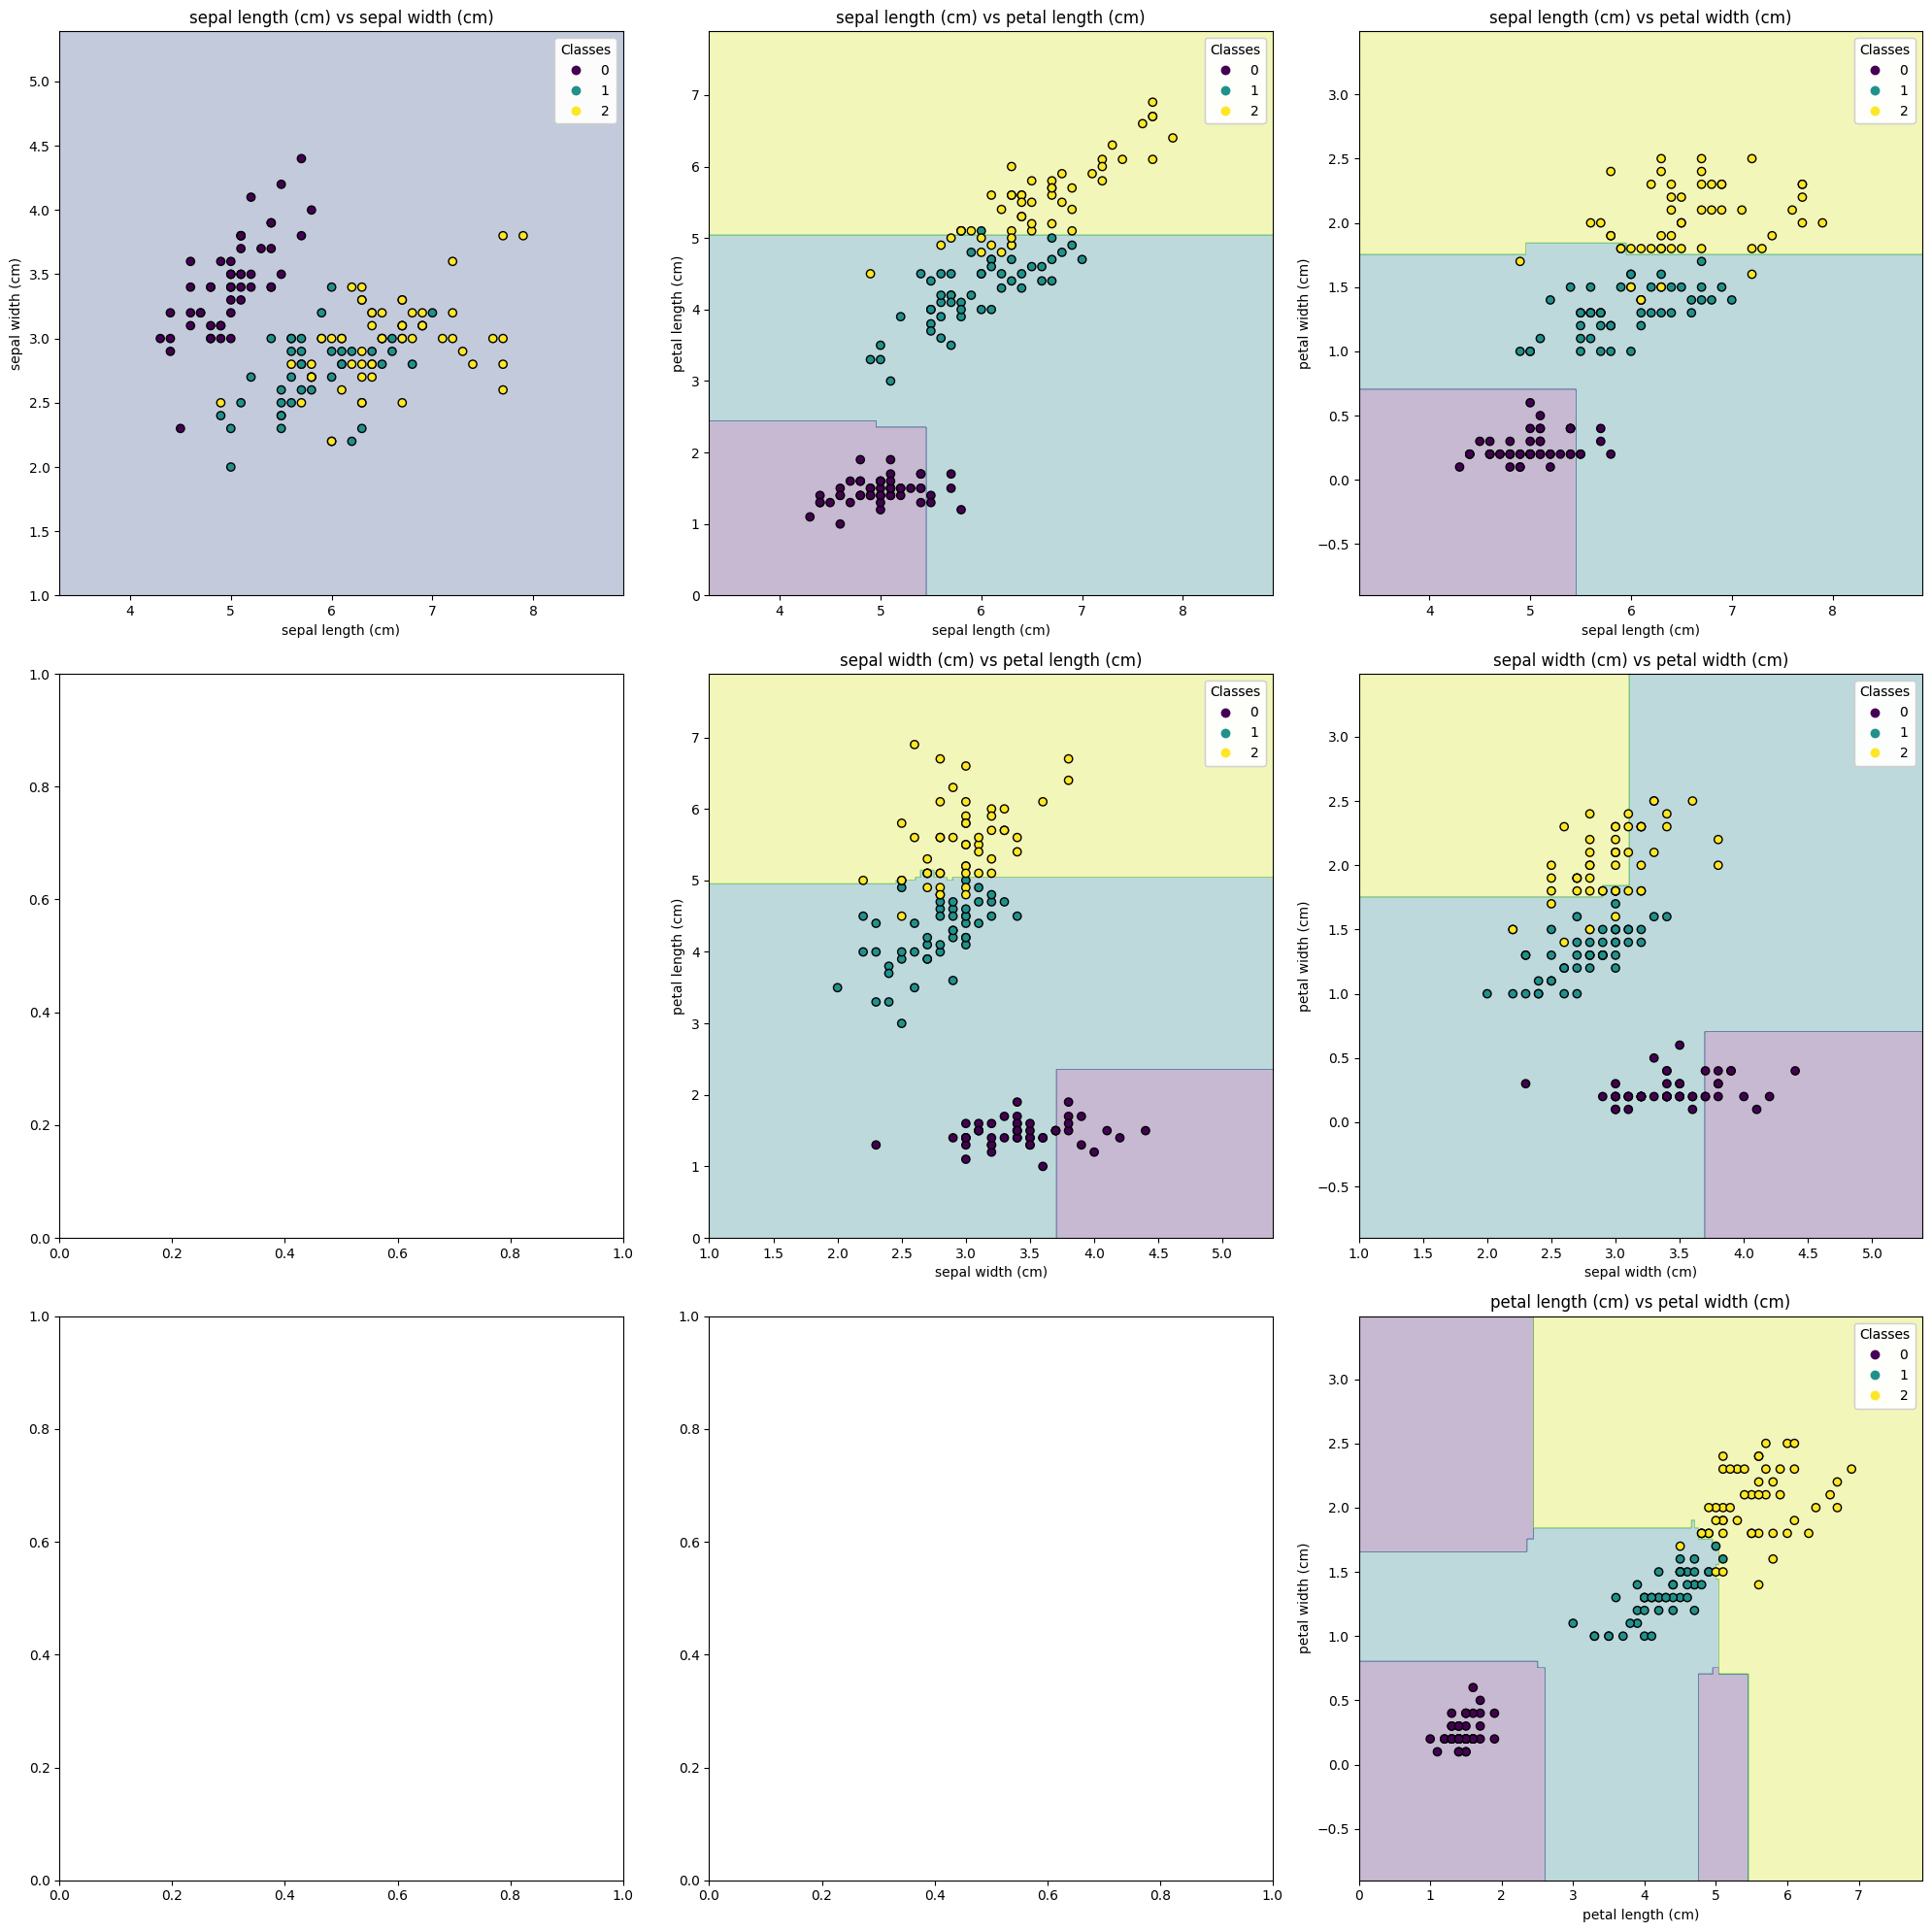

In [14]:
# Function to create a grid of decision boundary plots
def plot_all_decision_boundaries(clf, X, y):
    n_features = X.shape[1]
    fig, axes = plt.subplots(n_features - 1, n_features - 1, figsize=(20, 20))

    for i in range(n_features - 1):
        for j in range(i + 1, n_features):
            if i < j:
                plot_decision_boundaries(axes[i, j - 1], X, y, clf, feature_pair=[i, j])
            else:
                axes[i, j - 1].axis("off")

    plt.tight_layout()
    plt.show()

# Use the function to plot decision boundaries for the trained classifier
plot_all_decision_boundaries(rf, X, y)

# Choose an Instance to Explain
Choose a random instance from the test set to explain using LIME.

In [15]:
# Choose an instance to explain
instance_idx = random.randint(0, X_test.shape[0] - 1)
instance_input = X_test.iloc[instance_idx]
instance_output = y_test.iloc[instance_idx]

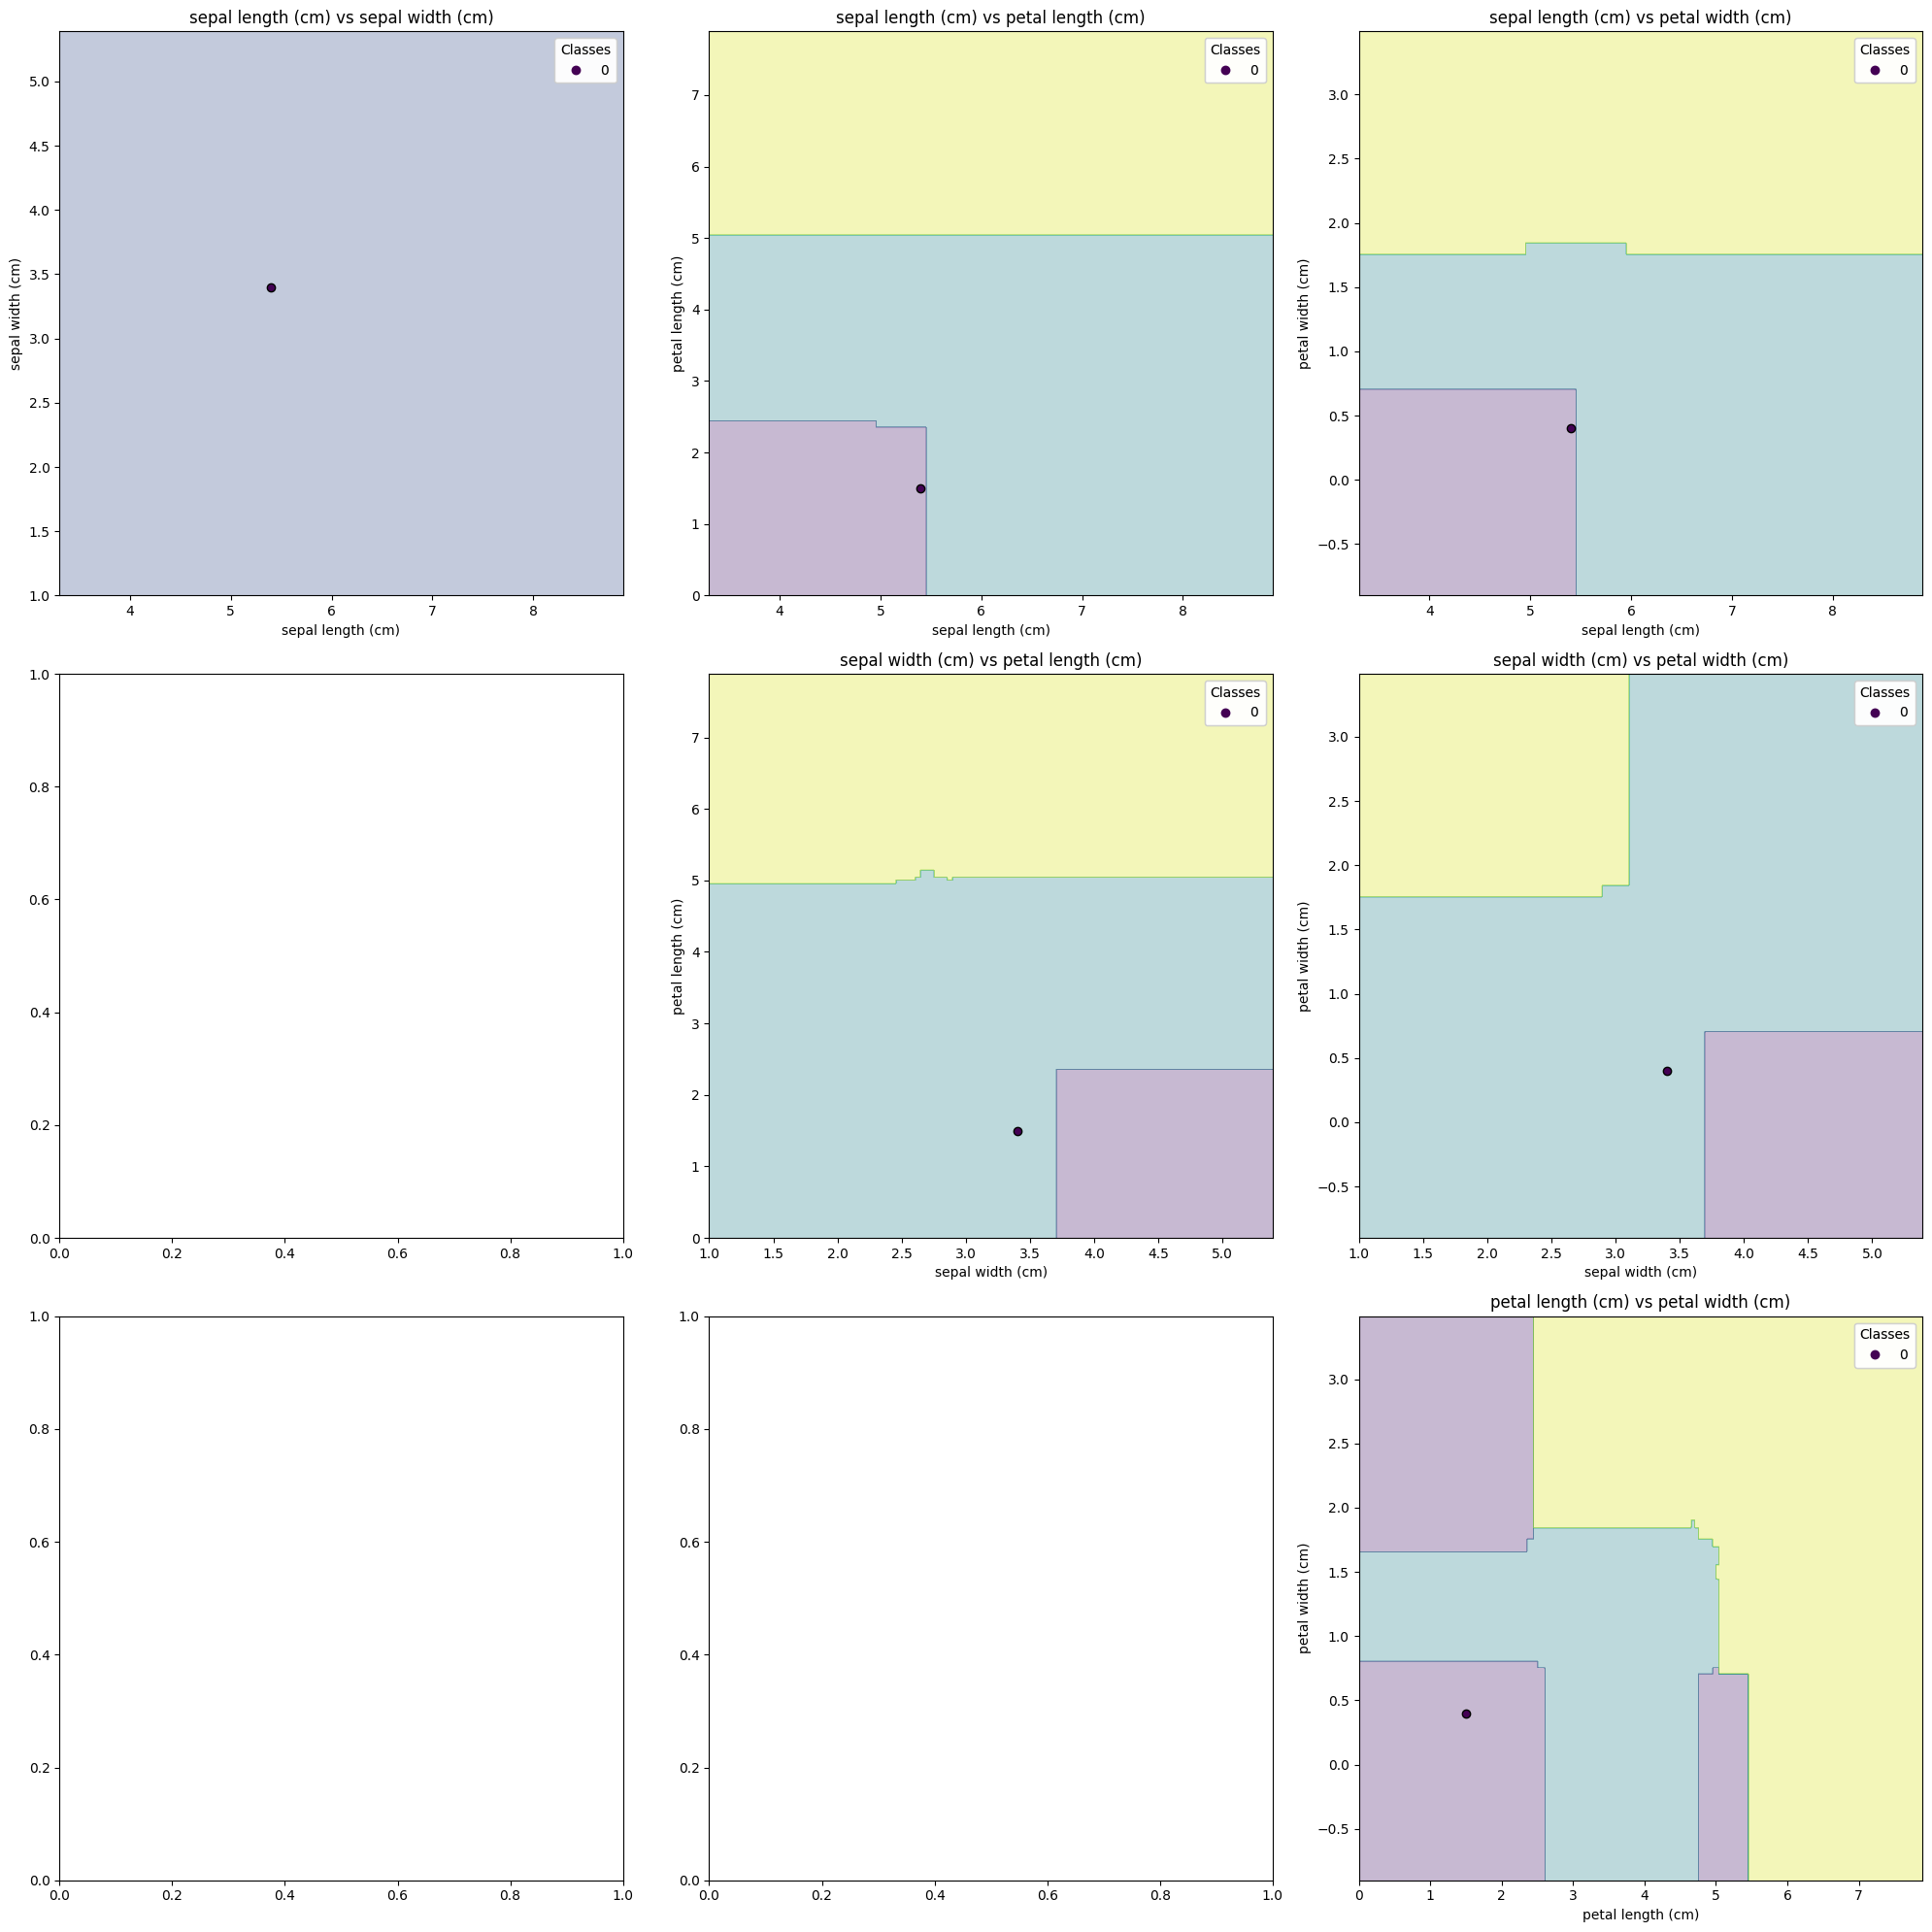

In [26]:
plot_all_decision_boundaries(rf, instance_input.to_frame().T, instance_output)

# Create a LIME Explainer
Create a LIME explainer and generate an explanation for the chosen instance.

In [27]:
# Create a LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=iris.target_names,
    discretize_continuous=True,
)

# Generate explanation
exp = explainer.explain_instance(instance_input.values, rf.predict_proba, num_features=4)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=True)

/Users/aritradas/miniforge3/envs/dsc291/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [29]:
# Extract the list of (feature, weight) tuples
feature_weights = exp.as_list()

# Display feature contributions
for feature, weight in feature_weights:
    print(f'Feature: {feature}, Weight: {weight}')

Feature: petal length (cm) <= 1.50, Weight: -0.19885654032731023
Feature: 0.30 < petal width (cm) <= 1.30, Weight: 0.1696265079538476
Feature: 3.00 < sepal width (cm) <= 3.40, Weight: 0.024208745208019578
Feature: 5.10 < sepal length (cm) <= 5.75, Weight: 0.01508339711856257


# Function to Perturb the Instance and See the Effect on the Prediction
Define a function to perturb the instance and observe the changes in prediction.

In [31]:
# Function to perturb the instance and see the effect on the prediction
def perturb_instance(instance, feature_index, new_value):
    perturbed_instance = instance.copy()
    perturbed_instance.iloc[feature_index] = new_value
    return perturbed_instance

# Choose a feature to perturb and a range of new values
feature_index = 0  # Perturb the first feature
new_values = pd.Series(
    np.linspace(X_train.iloc[:, feature_index].min(), X_train.iloc[:, feature_index].max(), num=10)
)

# Store the original prediction
original_prediction = rf.predict([instance_input])[0]

# Perturb the instance and observe the changes in prediction
for new_value in new_values:
    perturbed_instance = perturb_instance(instance_input, feature_index, new_value)
    new_prediction = rf.predict([perturbed_instance])[0]
    print(
        f"Original value: {instance_input.iloc[feature_index]}, New value: {new_value}, Original prediction: {original_prediction}, New prediction: {new_prediction}"
    )

Original value: 5.4, New value: 4.3, Original prediction: 0, New prediction: 0
Original value: 5.4, New value: 4.677777777777778, Original prediction: 0, New prediction: 0
Original value: 5.4, New value: 5.055555555555555, Original prediction: 0, New prediction: 0
Original value: 5.4, New value: 5.433333333333334, Original prediction: 0, New prediction: 0
Original value: 5.4, New value: 5.811111111111111, Original prediction: 0, New prediction: 0
Original value: 5.4, New value: 6.188888888888889, Original prediction: 0, New prediction: 0
Original value: 5.4, New value: 6.566666666666666, Original prediction: 0, New prediction: 0
Original value: 5.4, New value: 6.944444444444445, Original prediction: 0, New prediction: 0
Original value: 5.4, New value: 7.322222222222223, Original prediction: 0, New prediction: 0
Original value: 5.4, New value: 7.7, Original prediction: 0, New prediction: 0


/Users/aritradas/miniforge3/envs/dsc291/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/aritradas/miniforge3/envs/dsc291/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/aritradas/miniforge3/envs/dsc291/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/aritradas/miniforge3/envs/dsc291/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/aritradas/miniforge3/envs/dsc291/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but 